In [1]:
import nltk
import pandas as pd
nltk.download('popular', quiet=True)
import demoji
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import bigrams
from nltk import FreqDist
import spacy
import string
nltk.download("wordnet", quiet=True)
nltk.download("stopwords", quiet=True)
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import defaultdict
import pandas as pd
nlp = spacy.load("en_core_web_sm")


## 1. Perform necessary data preprocessing, e.g. removing punctuation and stop words, stemming, lemmatizing. You may use the outputs from previous weekly assignments. (10 points)


In [2]:
import os
import glob
def collect_data():
    text_file_pattern = "*.txt"  # You can adjust the pattern to match your file extensions
    text_files = glob.glob(os.path.join("../nhs/content", text_file_pattern))
    data = {}
    for file_path in text_files:
        with open(file_path, 'r', encoding='utf-8') as file:
            file_name = os.path.basename(file_path)
            file_content = file.read()
            data[file_name] = file_content
    return data


In [3]:
corpus = collect_data()
text = ""
for data in corpus:
    text += " " + data


In [4]:
def remove_punctuation(text):
    # Create a translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    # Use translate method to remove punctuation
    cleaned_text = text.translate(translator)
    return cleaned_text

def remove_stop_words(text):
    nltk_stopwords = stopwords.words('english')
    spacy_stopwords = nlp.Defaults.stop_words

    stop_words = (*nltk_stopwords, *spacy_stopwords, "NHStxt")

    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

def apply_lemmitization(text):
    tag_map = defaultdict(lambda : wordnet.NOUN)
    tag_map['V'] = wordnet.VERB
    tag_map['A'] = wordnet.ADJ
    tag_map['R'] = wordnet.ADJ

    lemmitizer = WordNetLemmatizer()
    lemmitized_result = ""
    tokens = word_tokenize(text)
    for token, tag in pos_tag(tokens):
        lemma = lemmitizer.lemmatize(token, tag_map[tag[0]])
        lemmitized_result = lemmitized_result + " " + lemma
    return lemmitized_result

def remove_emoji_and_smart_quotes(text):
    # replacing emojis with description
    text = demoji.replace_with_desc(text)
    #Removing smart quotes
    return text.replace(""", "\"").replace(""","\"")


In [5]:
def data_preprocessing(text):
    text = remove_emoji_and_smart_quotes(text)
    text = remove_punctuation(text)
    text = remove_stop_words(text)
    text = apply_lemmitization(text)
    return text

def apply_data_preprocessing_to_corpus(corpus):
    new_corpus = {}
    for idx, key in enumerate(corpus.keys()):
        new_corpus[key] = data_preprocessing(corpus[key])
        print(f"idx: {idx}")
    return new_corpus


In [6]:
processed_text = data_preprocessing(text)
with open('week8_1.txt', 'w') as file:
    file.write(f'{processed_text}')


## 2. Generate additional training data for your project by substituting different words with the same superordinate term in different sentence patterns. (30 points)


In [7]:
from nltk.corpus import wordnet as wn
import random

In [8]:

def get_simple_names(word):
    words = []
    for i in wn.synsets(word):
        words += i.lemma_names()
    return words

In [9]:
def create_additional_data(n=1):
    data = []
    for i in range(n):
        new_text = ""
        for token in word_tokenize(processed_text):
            simples = get_simple_names(token)
            if random.random() < 0.1 and len(simples) > 0 and len(simples) < 10:
                new_text += random.choice(get_simple_names(token)) + " "
            else:
                new_text += token + " "
        data.append(new_text)
    return data

In [10]:
additional_data = create_additional_data(3)

In [11]:
len(additional_data), additional_data[0][:100]

(3,
 'Food colour hyperactivity Lung health check Carotid endarterectomy Middle East respiratory syndrome ')

## 3. Perform context-free grammars and parsing on one of sentences in your project data.  (20 points)

In [12]:
import svgling
import graphviz
# svgling.disable_nltk_png()

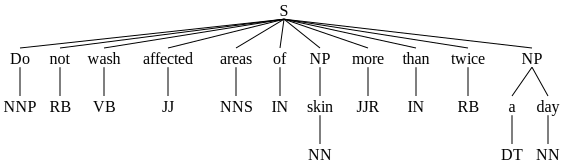

In [13]:
sentence = "Do not wash affected areas of skin more than twice a day"
sent_tokens = nltk.pos_tag(word_tokenize(sentence))
grammar = r"NP:{<DT>?<JJ>*<NN>}"
chunk_parser = nltk.RegexpParser(grammar)
chunk_parser.parse(sent_tokens)

(S (NP (N stress)) (VP (V creates) (NP (N acne))))


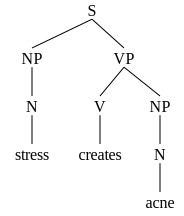

In [14]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> N
VP -> V NP
N -> "stress" | "acne"
V -> "creates"
""")
# example sentence that can be parsed with the grammar we've defined
sent = nltk.word_tokenize("stress creates acne")
# create a chart parser based on the grammar above
parser = nltk.ChartParser(grammar)
# parse the sentence
trees = list(parser.parse(sent))
# print a text-formatted parse tree
print(trees[0])
# print an SVG formatted parse tree
trees[0]

## 4. Develop search criteria for your project and perform slot filling and slot visualization.  (40 points)


In [15]:
import spacy
from spacy.lang.en import English
nlp = English()
ruler = nlp.add_pipe("entity_ruler")
symptom_patterns = [
    {"label": "SYMPTOM", "pattern": "rash"},
    {"label": "SYMPTOM", "pattern": "cough"},
    {"label": "SYMPTOM", "pattern": "cold"},
    {"label": "SYMPTOM", "pattern": "red eyes"},
    {"label": "SYMPTOM", "pattern": "drowsy"},
    {"label": "SYMPTOM", "pattern": "hair loss"}]
day_patterns = [
    {"label": "RELATIVE_DATE", "pattern": "today"},
    {"label": "RELATIVE_DATE", "pattern": "yesterday"},
    {"label": "RELATIVE_DATE", "pattern": "tomorrow"}]
location_patterns = [
    {"label": "LOCATION", "pattern": "home"},
    {"label": "LOCATION", "pattern": "office"},
    {"label": "LOCATION", "pattern": "san francisco"},
    {"label": "LOCATION", "pattern": "stockton"}]
ruler.add_patterns(symptom_patterns)
ruler.add_patterns(day_patterns)
ruler.add_patterns(location_patterns)
ruler.add_patterns(location_patterns)
doc = nlp("I am having bad cough today. im in my home in san francisco")
print([(ent.text, ent.label_) for ent in doc.ents])


[('cough', 'SYMPTOM'), ('today', 'RELATIVE_DATE'), ('home', 'LOCATION'), ('san francisco', 'LOCATION')]


In [16]:
from spacy import displacy
colors = {
    "SYMPTOM": "#ea7e7e",
    "RELATIVE_DATE": "#baffc9",
    "LOCATION": "#ffffba"
}
options = {"ents": ["SYMPTOM","RELATIVE_DATE","LOCATION"],
           "colors": colors}
displacy.render(doc, style="ent", options=options,jupyter = True)
